In the notebook `infermean_identify_highbias`, we tried to understand the cause of the positive bias in imputed mean temperatures.
We found that the imputations were particularly off on December 2nd at KBDL.
The true mean temperature on that day (17:00 UTC to to 17:00 UTC on December 2nd) was 3.375°C. 
The imputed mean temperature was 3.886°C ± 0.122: a >4σ error.

One hypothesis is that this is caused by the discrepancy between smoothmin and smoothmax, as on that the the temperatures stay low for a while.
We see a similar pattern (and magnitude of error) on June 2nd.

In [1]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=120.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=120.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [2]:
using Printf
using DataFrames
using JLD
using Dates
using GaussianProcesses: set_params!
import JSON
using Dates
using PDMats
using LinearAlgebra
using Statistics
using StatsBase: midpoints, Weights
using Distributions
using GaussianProcesses
using CmdStan

GPmodel="matern"
ICAO="KBDL"
data_dir="../data"
save_dir="/Volumes/Samsung250GB/saved"
k_nearest=5

5

In [3]:
using Revise
import TempModel

In [4]:
module Batch
    using TempModel
    import PyPlot; plt=PyPlot
    using LaTeXStrings
    using DataFrames
    using Dates
    using Distributions
    using PDMats
    using LinearAlgebra
    using Printf
    ;
    src_dir = dirname(pathof(TempModel))
    include(joinpath(src_dir, "batch_diagnostics.jl"))
    include(joinpath(src_dir, "plot_diagnostics.jl"))
    include(joinpath(src_dir, "infermean.jl"))
#     include(joinpath(src_dir, "plot_map.jl"))
end

Main.Batch

In [5]:
# load kernel hyperparameters from JSON file
json_fname = @sprintf("hyperparams_%s_%s.json", GPmodel, ICAO)
json_filepath = joinpath(save_dir, "fitted_kernel", GPmodel, json_fname)
open(json_filepath, "r") do io
    global output_dictionary = JSON.parse(io)
end
@assert output_dictionary["test_ICAO"] == ICAO

epsg = 3857 # Web Mercator (m)
isdList = TempModel.read_isdList(; data_dir=data_dir, epsg=epsg)
isd_wData = TempModel.stations_with_data(isdList; data_dir=data_dir)

test_station = isd_wData[isd_wData[:ICAO].==ICAO, :]
@assert nrow(test_station) == 1
USAF = test_station[1, :USAF]
WBAN = test_station[1, :WBAN]

isd_nearest_and_test = TempModel.find_nearest(isd_wData, USAF, WBAN, k_nearest)

hourly_cat=TempModel.read_Stations(isd_nearest_and_test; data_dir=data_dir)
itest=1 # first row of isd_nearest_and_test is the test station
timezoneGMT = -5 # Georgia
# timezoneGMT = -7 # Arizona
local_time(ts) = ts - Hour(timezoneGMT)
ilocaltime = circshift(1:24, -timezoneGMT)
;

┌ Warning: dropmissing! will change eltype of cols to disallow missing by default. Use dropmissing!(df, cols, disallowmissing=false) to retain missing.
│   caller = dropmissing!(::DataFrame) at abstractdataframe.jl:733
└ @ DataFrames /Users/imolk/Library/Julia/alternative_depots/climate/packages/DataFrames/IKMvt/src/abstractdataframe/abstractdataframe.jl:733


In [6]:
hr_measure = Hour(17)
TnTx = TempModel.test_data(hourly_cat, itest, hr_measure)
hourly_train = hourly_cat[hourly_cat[:station].!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].==itest,:]
hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_measure) for t in hourly_test[:ts]]
# add column to test data for TnTx (useful for plotting)
hourly_test = join(hourly_test, TnTx, on=:ts_day)
;

# Running Stan

In [10]:
test_fw = Batch.FittingWindow(Date(2015,10,20),Date(2016,1,1))
nearby_pred = Batch.get_nearby(test_fw, GPmodel, USAF, WBAN, ICAO, save_dir)
date_start = Date(2015,11,29)
impute_window = Day(7)
stan_data, ts_window = TempModel.prep_data(nearby_pred, TnTx, date_start, hr_measure, impute_window;
    ksmoothmax=10.0, epsilon=0.01) # relaxed k, strict epsilon
imputation_model = TempModel.get_imputation_model() # Stan model
;

=====> /Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks



In [11]:
@time sim1 = stan(imputation_model, [stan_data], summary=true, diagnostics=false);


make: `/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation' is up to date.


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be e


If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempM

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be 


Calling /usr/local/Cellar/cmdstan/2.17.0/bin/stansummary to infer across chains.

Inference for Stan model: imputation_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (414, 403, 400, 384) seconds, 27 minutes total
Sampling took (464, 466, 466, 468) seconds, 31 minutes total

                     Mean     MCSE   StdDev        5%       50%       95%  N_Eff  N_Eff/s    R_hat
lp__             -1.2e+02  2.8e-01  1.0e+01  -1.4e+02  -1.2e+02  -1.0e+02   1346  7.2e-01  1.0e+00
accept_stat__     9.4e-01  1.3e-03  8.2e-02   7.6e-01   9.7e-01   1.0e+00   4000  2.1e+00  1.0e+00
stepsize__        1.7e-03  8.4e-05  1.2e-04   1.5e-03   1.8e-03   1.8e-03    2.0  1.1e-03  4.7e+13
treedepth__       1.0e+01  2.7e-15  1.7e-13   1.0e+01   1.0e+01   1.0e+01   4000  2.1e+00  1.0e+00
n_leapfrog__      1.0e+03  2.8e-13  1.8e-11   1.0e+03   1.0e+03   1.0e+03   4000  2.1e+00  1.0e+00
divergent__       0.0e+00  0.0e+00  0.0e+00   0.0e+00

925.135450 seconds (20.83 M allocations: 935.082 MiB, 0.11% gc time)


In [12]:
using AxisArrays
function Chains(samples::AbstractArray{Float64, 3}, names::AbstractVector{S}) where {S<:AbstractString}
    nsamples, ncol, nchains = size(samples)
    chains = AxisArray(samples, Axis{:sample}(1:nsamples), Axis{:param}(names), Axis{:chain}(1:nchains))
    return chains
end
function get_param_names(chains::AxisArray)
    # there should be a more elegant way to obtain the names of an axis
    PARAM = Axis{:param}
    jparam = axisdim(chains, PARAM)
    param_axis = AxisArrays.axes(chains)[jparam]
    param_names = axisvalues(param_axis)[1]
    return param_names
end
function get_temperatures_reparam(chains::AxisArray)
    param_names = get_param_names(chains)
    temp_varnames = [h for h in param_names if startswith(h, "temp_impt.")]
    temp_samples = view(chains, :, Axis{:param}(temp_varnames), :)
    return temp_samples
end
chainsarray = Chains(sim1[2], sim1[3])
@show size(chainsarray)
temp_impute = get_temperatures_reparam(chainsarray);

size(chainsarray) = (1000, 511, 4)


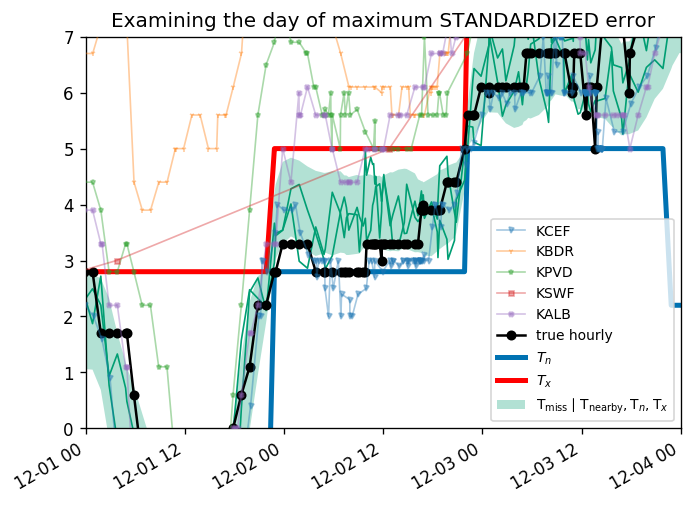

In [17]:
plt.title("Examining the day of maximum STANDARDIZED error")
Batch.plot_imputations(ts_window, temp_impute, local_time; plot_mean=false, impt_indices=[250,500])
plt.gcf()[:autofmt_xdate]()
plt.xlim(Date(2015,12,1), Date(2015,12,4))
plt.ylim(0,7)
_xlim = plt.xlim()
_ylim = plt.ylim()
Batch.plot_neighbours(hourly_train, 
                      isd_nearest_and_test,
                      local_time,
                      (DateTime(2015,11,15), DateTime(2015,12,15));
                      subtractmean=false,
#                       color="black",
                      linewidth=1,
                      markersize=3,
                      alpha=0.4,
                      zorder=10)
fw = Batch.FittingWindow(DateTime(2015,11,27,0,0,0), DateTime(2015,12,6,0,0,0))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
plt.legend(loc="auto", fontsize="small")
;

# Sidetrack: using built-in LogSumExp function

In [19]:
function get_imputation_model_LSE(; pdir=pwd())
    imputation_model = """
        functions {
            real smoothmax(vector x, real k){
                return log_sum_exp(k*x);
            }
            real smoothmin(vector x, real k){
                return -log_sum_exp(-k*x);
            }
        }
        data {
            // Tn Tx data
            int<lower=1> N_TxTn; //
            vector[N_TxTn] Tx;
            vector[N_TxTn] Tn;

            // imputation points (for which we have )
            int<lower=1> Nimpt;
            int<lower=1,upper=N_TxTn> day_impute[Nimpt];
            // number of hours recorded within each day
            int<lower=1> impt_times_p_day[N_TxTn];

            // prior 
            vector[Nimpt] predicted_mean;
            matrix[Nimpt,Nimpt] predicted_cov;
            matrix[Nimpt,Nimpt] predicted_cov_chol;

            // control smooth max hardness
            real<lower=0> k_smoothmax;
            // real<lower=0> sigma_mu;
            real<lower=0> epsilon;
        }
        parameters {
            vector[Nimpt] w_uncorr;
            // real mu;
        }
        transformed parameters {
            vector[Nimpt] temp_impt;
            real Tsmoothmax[N_TxTn];
            real Tsmoothmin[N_TxTn];  
            // temp_impt = mu + predicted_mean + predicted_cov_chol*w_uncorr;
            temp_impt = predicted_mean + predicted_cov_chol*w_uncorr;
            {
                int istart;
                istart = 1;
                for (i in 1:N_TxTn){
                    int ntimes;
                    ntimes = impt_times_p_day[i];
                    Tsmoothmin[i] = smoothmin(segment(temp_impt,istart,ntimes), 
                                              k_smoothmax);
                    Tsmoothmax[i] = smoothmax(segment(temp_impt,istart,ntimes), 
                                              k_smoothmax);
                    istart = istart + ntimes;
                }
            }
        }
        model {
            w_uncorr ~ normal(0,1);
            // mu ~ normal(0, sigma_mu);
            Tn ~ normal(Tsmoothmin, epsilon);
            Tx ~ normal(Tsmoothmax, epsilon);
        }

    """
    stanmodel = Stanmodel(;
            name="imputation_LSE", 
            model=imputation_model, 
            pdir=pdir, 
        )
    return stanmodel
end

get_imputation_model_LSE (generic function with 1 method)

In [20]:
imputation_model_LSE = get_imputation_model_LSE() # Stan model
;

=====> /Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks


File /Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation_LSE.stan will be updated.



In [21]:
@time simLSE = stan(imputation_model_LSE, [stan_data], summary=true, diagnostics=false);



--- Translating Stan model to C++ code ---
bin/stanc  /Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation_LSE.stan --o=/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation_LSE.hpp
Model name=imputation_LSE_model
Input file=/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation_LSE.stan
Output file=/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation_LSE.hpp

--- Linking C++ model ---
clang++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -I src -I stan/src -isystem stan/lib/stan_math/ -DEIGEN_NO_DEBUG -DFUSION_MAX_VECTOR_SIZE=12 -stdlib=libc++ -Wno-unknown-warning-option -Wno-unused-function -Wno-tautological-compare -Wsign-compare -DNO_FPRINTF_OUTPUT -pipe   -O3 -o /Users/imolk/Docum

778.984654 seconds (14.95 M allocations: 647.658 MiB, 0.08% gc time)


This is faster, but for some reason the effective sample sizes (ESS) for all parameters are **much** lower, so we can't use this. How bizarre.

# Given STAN the softmin and softmax rather than Tn/Tx

In [37]:
smoothmax(x, k, maxkx) = (maxkx + log(sum(xi ->exp(k*xi - maxkx), x)))/k
smoothmax(x, k) = smoothmax(x, k, maximum(x)*k)
smoothmin(x, k, minkx) = (minkx - log(sum(xi ->exp(-k*xi + minkx), x)))/k
smoothmin(x, k) = smoothmin(x, k, minimum(x)*k)
function smooth_TnTx(hourly::DataFrame, istation::Int, hr_measure::Hour, ksmoothmax::Real)
    hourly_test = hourly[hourly[:station] .== istation,:]
    hourly_test[:ts_day] = TempModel.measurement_date.(hourly_test[:ts], hr_measure)
    TnTx = DataFrames.by(hourly_test, :ts_day, df -> DataFrame(
        Tn=smoothmin(df[:temp], ksmoothmax), 
        Tx=smoothmax(df[:temp], ksmoothmax),
        Tn_time=df[:ts][argmin(df[:temp])],
        Tx_time=df[:ts][argmax(df[:temp])],
        times_p_day=DataFrames.nrow(df),
    ))
    return TnTx
end
TnTx_smooth = smooth_TnTx(hourly_test, 1, hr_measure, 10.0)
TnTx_smooth[1:3,[:Tn,:Tx]], TnTx[1:3,[:Tn,:Tx]]

(3×2 DataFrame
│ Row │ Tn       │ Tx         │
│     │ Float64  │ Float64    │
├─────┼──────────┼────────────┤
│ 1   │ -10.6    │ 1.67018e-6 │
│ 2   │ -1.70026 │ 2.86944    │
│ 3   │ -5.16094 │ 3.41031    │, 3×2 DataFrame
│ Row │ Tn      │ Tx      │
│     │ Float64 │ Float64 │
├─────┼─────────┼─────────┤
│ 1   │ -10.6   │ 0.0     │
│ 2   │ -1.7    │ 2.8     │
│ 3   │ -5.0    │ 3.3     │)

In [38]:
stan_data_smooth, ts_window = TempModel.prep_data(nearby_pred, TnTx_smooth, date_start, hr_measure, impute_window;
    ksmoothmax=10.0, epsilon=0.01) # relaxed k, strict epsilon
@time sim_smooth = stan(imputation_model, [stan_data_smooth], summary=true, diagnostics=false);


make: `/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation' is up to date.


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)


If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,If this warning occurs sporadically, such as for highly constrained variable

but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types li


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)


Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

but if this warning occurs often then your model may be 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be ei


Calling /usr/local/Cellar/cmdstan/2.17.0/bin/stansummary to infer across chains.

Inference for Stan model: imputation_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (386, 386, 396, 385) seconds, 26 minutes total
Sampling took (452, 452, 450, 452) seconds, 30 minutes total

                     Mean     MCSE   StdDev        5%       50%       95%  N_Eff  N_Eff/s    R_hat
lp__             -1.2e+02  3.0e-01  1.0e+01  -1.4e+02  -1.2e+02  -1.0e+02   1216  6.7e-01  1.0e+00
accept_stat__     9.3e-01  1.4e-03  8.9e-02   7.4e-01   9.7e-01   1.0e+00   4000  2.2e+00  1.0e+00
stepsize__        1.7e-03  6.9e-05  9.7e-05   1.6e-03   1.8e-03   1.8e-03    2.0  1.1e-03  2.8e+13
treedepth__       1.0e+01  2.7e-15  1.7e-13   1.0e+01   1.0e+01   1.0e+01   4000  2.2e+00  1.0e+00
n_leapfrog__      1.0e+03  2.8e-13  1.8e-11   1.0e+03   1.0e+03   1.0e+03   4000  2.2e+00  1.0e+00
divergent__       0.0e+00  0.0e+00  0.0e+00   0.0e+00

872.622370 seconds (14.95 M allocations: 642.413 MiB, 0.04% gc time)


In [39]:
chainsarray = Chains(sim_smooth[2], sim_smooth[3])
@show size(chainsarray)
temp_impute_smooth = get_temperatures_reparam(chainsarray);

size(chainsarray) = (1000, 511, 4)


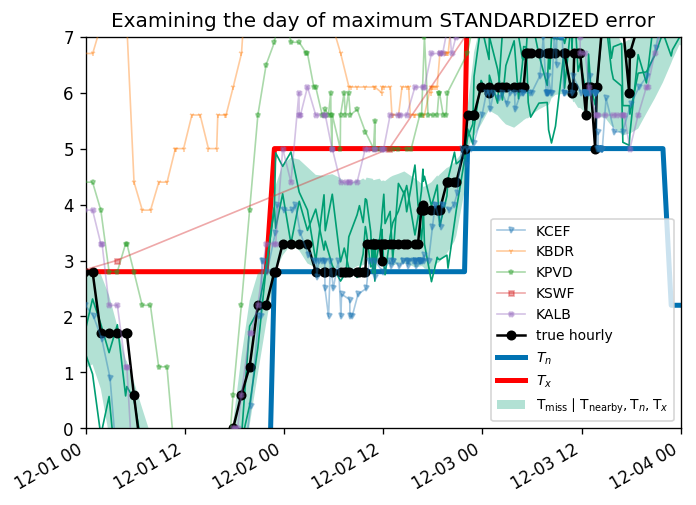

In [40]:
plt.title("Examining the day of maximum STANDARDIZED error")
Batch.plot_imputations(ts_window, temp_impute_smooth, local_time; plot_mean=false, impt_indices=[250,500])
plt.gcf()[:autofmt_xdate]()
plt.xlim(Date(2015,12,1), Date(2015,12,4))
plt.ylim(0,7)
_xlim = plt.xlim()
_ylim = plt.ylim()
Batch.plot_neighbours(hourly_train, 
                      isd_nearest_and_test,
                      local_time,
                      (DateTime(2015,11,15), DateTime(2015,12,15));
                      subtractmean=false,
#                       color="black",
                      linewidth=1,
                      markersize=3,
                      alpha=0.4,
                      zorder=10)
fw = Batch.FittingWindow(DateTime(2015,11,27,0,0,0), DateTime(2015,12,6,0,0,0))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
plt.legend(loc="auto", fontsize="small")
;

# Comparison

In [45]:
december2 = hourly_test[hourly_test[:ts_day] .== Date(2015,12,2), :]
true_mean_december2 = mean(december2[:temp])

3.375510204081634

In [44]:
impute_december2 = temp_impute[
    :, # samples
    [t ∈ december2[:ts] for t in ts_window], # time
    :] # chain
;
impute_december2_smooth = temp_impute_smooth[
    :, # samples
    [t ∈ december2[:ts] for t in ts_window], # time
    :] # chain
;
mean(impute_december2), mean(impute_december2_smooth)

(3.886089263061224, 3.7466953915816323)

In [55]:
imputedmean = Float64[]
for isample in 1:size(impute_december2,1)
    for ichain in 1:4
        temp = impute_december2[isample,:,ichain]
        push!(imputedmean, mean(temp))
    end
end
imputedmean_smooth = Float64[]
for isample in 1:size(impute_december2,1)
    for ichain in 1:4
        temp = impute_december2_smooth[isample,:,ichain]
        push!(imputedmean_smooth, mean(temp))
    end
end

In [56]:
sigma_impute = (mean(imputedmean)-true_mean_december2)/std(imputedmean)
sigma_smooth = (mean(imputedmean_smooth)-true_mean_december2)/std(imputedmean_smooth)
sigma_impute, sigma_smooth

(5.0733852390955665, 2.9996294008099946)

In `infermean_identify_highbias` we saw errors >4σ, which was from the odyssey output with k=20 and a 9-day window. Here we have k=10 and a 7-day window.
We *do* see an improvement feeding the algorithm the smoothmin and smoothmax instead of Tn/Tx, as the error drops to 3σ.
It still seems like 3σ is a lot.

# Does the error go down with a bigger epsilon?

In [59]:
stan_data_relax, ts_window = TempModel.prep_data(nearby_pred, TnTx, date_start, hr_measure, impute_window;
    ksmoothmax=10.0, epsilon=0.1) # relaxed k, relaxed epsilon
@time sim_relax = stan(imputation_model, [stan_data_relax], summary=false, diagnostics=false);
;


make: `/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation' is up to date.


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be 

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)


but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly const

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be e

283.295713 seconds (14.94 M allocations: 641.689 MiB, 0.19% gc time)


It's certainly faster!

In [60]:
chainsarray = Chains(sim_relax[2], sim_relax[3])
temp_impute_relax = get_temperatures_reparam(chainsarray);
impute_december2_relax = temp_impute_relax[
    :, # samples
    [t ∈ december2[:ts] for t in ts_window], # time
    :] # chain
imputedmean_relax = Float64[]
for isample in 1:size(impute_december2,1)
    for ichain in 1:4
        temp = impute_december2_relax[isample,:,ichain]
        push!(imputedmean_relax, mean(temp))
    end
end

In [61]:
sigma_relax = (mean(imputedmean_relax)-true_mean_december2)/std(imputedmean_relax)

3.970198417738269

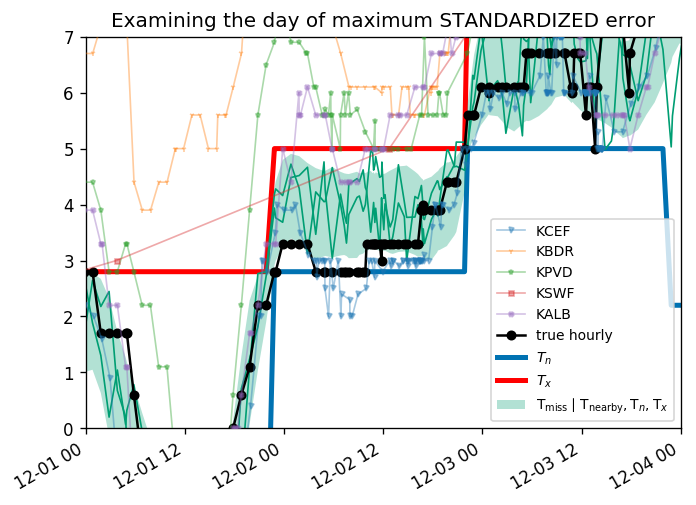

In [62]:
plt.title("Examining the day of maximum STANDARDIZED error")
Batch.plot_imputations(ts_window, temp_impute_relax, local_time; plot_mean=false, impt_indices=[250,500])
plt.gcf()[:autofmt_xdate]()
plt.xlim(Date(2015,12,1), Date(2015,12,4))
plt.ylim(0,7)
_xlim = plt.xlim()
_ylim = plt.ylim()
Batch.plot_neighbours(hourly_train, 
                      isd_nearest_and_test,
                      local_time,
                      (DateTime(2015,11,15), DateTime(2015,12,15));
                      subtractmean=false,
#                       color="black",
                      linewidth=1,
                      markersize=3,
                      alpha=0.4,
                      zorder=10)
fw = Batch.FittingWindow(DateTime(2015,11,27,0,0,0), DateTime(2015,12,6,0,0,0))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
plt.legend(loc="auto", fontsize="small")
;

Yes, the error has gone down from 5σ to 4σ, which is something.

# Does the error go down with a wider window?

In [63]:
impute_window = Day(12)
stan_data_wide, ts_window = TempModel.prep_data(nearby_pred, TnTx, date_start, hr_measure, impute_window;
    ksmoothmax=10.0, epsilon=0.1) # relaxed k, relaxed epsilon
@time sim_wide = stan(imputation_model, [stan_data_wide], summary=false, diagnostics=false);
;


make: `/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation' is up to date.


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be ei

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be e

1225.109769 seconds (26.12 M allocations: 1.107 GiB, 0.04% gc time)


In [65]:
chainsarray = Chains(sim_wide[2], sim_wide[3])
temp_impute_wide = get_temperatures_reparam(chainsarray);
impute_december2_wide = temp_impute_wide[
    :, # samples
    [t ∈ december2[:ts] for t in ts_window], # time
    :] # chain
imputedmean_wide = Float64[]
for isample in 1:size(impute_december2,1)
    for ichain in 1:4
        temp = impute_december2_wide[isample,:,ichain]
        push!(imputedmean_wide, mean(temp))
    end
end
sigma_wide = (mean(imputedmean_wide)-true_mean_december2)/std(imputedmean_wide)

3.883156296813051

Very small, but non-zero, improvement.

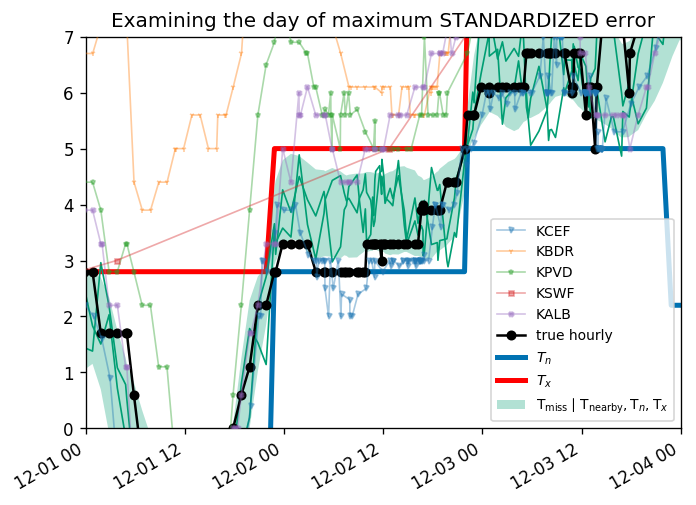

In [66]:
plt.title("Examining the day of maximum STANDARDIZED error")
Batch.plot_imputations(ts_window, temp_impute_wide, local_time; plot_mean=false, impt_indices=[250,500])
plt.gcf()[:autofmt_xdate]()
plt.xlim(Date(2015,12,1), Date(2015,12,4))
plt.ylim(0,7)
_xlim = plt.xlim()
_ylim = plt.ylim()
Batch.plot_neighbours(hourly_train, 
                      isd_nearest_and_test,
                      local_time,
                      (DateTime(2015,11,15), DateTime(2015,12,15));
                      subtractmean=false,
#                       color="black",
                      linewidth=1,
                      markersize=3,
                      alpha=0.4,
                      zorder=10)
fw = Batch.FittingWindow(DateTime(2015,11,27,0,0,0), DateTime(2015,12,6,0,0,0))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
plt.legend(loc="auto", fontsize="small")
;

# Does the error go down with a steeper k?

In [67]:
impute_window = Day(7)
stan_data_steep, ts_window = TempModel.prep_data(nearby_pred, TnTx, date_start, hr_measure, impute_window;
    ksmoothmax=30.0, epsilon=0.1) # strict k, relaxed epsilon
@time sim_steep = stan(imputation_model, [stan_data_steep], summary=true, diagnostics=false);
;


make: `/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation' is up to date.


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be e

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempM

277.451551 seconds (14.94 M allocations: 641.694 MiB, 0.19% gc time)


Encouragingly, this didn't take longer! But we need to look at the effective sample size.

In [68]:
chainsarray = Chains(sim_steep[2], sim_steep[3])
temp_impute_steep = get_temperatures_reparam(chainsarray);
impute_december2_steep = temp_impute_steep[
    :, # samples
    [t ∈ december2[:ts] for t in ts_window], # time
    :] # chain
imputedmean_steep = Float64[]
for isample in 1:size(impute_december2,1)
    for ichain in 1:4
        temp = impute_december2_steep[isample,:,ichain]
        push!(imputedmean_steep, mean(temp))
    end
end
sigma_steep = (mean(imputedmean_steep)-true_mean_december2)/std(imputedmean_steep)

3.3396719791653737

Yes, again, we see a moderate reduction.
Now let's go up to 50.

In [71]:
impute_window = Day(7)
stan_data_steep, ts_window = TempModel.prep_data(nearby_pred, TnTx, date_start, hr_measure, impute_window;
    ksmoothmax=50.0, epsilon=0.1) # strict k, relaxed epsilon
@time sim_steep = stan(imputation_model, [stan_data_steep], summary=true, diagnostics=false);
;


make: `/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation' is up to date.


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be 

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempM


Calling /usr/local/Cellar/cmdstan/2.17.0/bin/stansummary to infer across chains.

Inference for Stan model: imputation_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (159, 153, 159, 164) seconds, 11 minutes total
Sampling took (126, 127, 127, 125) seconds, 8.4 minutes total

                     Mean     MCSE   StdDev        5%       50%       95%  N_Eff  N_Eff/s    R_hat
lp__             -1.2e+02  2.5e-01  1.1e+01  -1.4e+02  -1.2e+02  -1.0e+02   1698  3.4e+00  1.0e+00
accept_stat__     9.3e-01  1.3e-03  8.5e-02   7.5e-01   9.7e-01   1.0e+00   4000  7.9e+00  1.0e+00
stepsize__        1.7e-02  4.8e-04  6.8e-04   1.6e-02   1.7e-02   1.8e-02    2.0  4.0e-03  5.3e+13
treedepth__       8.0e+00  8.4e-17  5.3e-15   8.0e+00   8.0e+00   8.0e+00   4000  7.9e+00  1.0e+00
n_leapfrog__      2.5e+02  4.9e-14  3.1e-12   2.6e+02   2.6e+02   2.6e+02   4000  7.9e+00  1.0e+00
divergent__       0.0e+00  0.0e+00  0.0e+00   0.0e+0

313.653972 seconds (14.94 M allocations: 642.046 MiB, 0.09% gc time)


In [72]:
chainsarray = Chains(sim_steep[2], sim_steep[3])
temp_impute_steep = get_temperatures_reparam(chainsarray);
impute_december2_steep = temp_impute_steep[
    :, # samples
    [t ∈ december2[:ts] for t in ts_window], # time
    :] # chain
imputedmean_steep = Float64[]
for isample in 1:size(impute_december2,1)
    for ichain in 1:4
        temp = impute_december2_steep[isample,:,ichain]
        push!(imputedmean_steep, mean(temp))
    end
end
sigma_steep = (mean(imputedmean_steep)-true_mean_december2)/std(imputedmean_steep)

3.1675283522362756

This is really interesting. Steeper $k$ doesn't seem to affect convergence, but does reduce error. This is looking like a free lunch. Let's keep going.

In [73]:
impute_window = Day(7)
stan_data_steep, ts_window = TempModel.prep_data(nearby_pred, TnTx, date_start, hr_measure, impute_window;
    ksmoothmax=100.0, epsilon=0.1) # strict k, relaxed epsilon
@time sim_steep = stan(imputation_model, [stan_data_steep], summary=true, diagnostics=false);
;


make: `/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation' is up to date.


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be ei

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be e


Calling /usr/local/Cellar/cmdstan/2.17.0/bin/stansummary to infer across chains.

Inference for Stan model: imputation_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (157, 157, 152, 156) seconds, 10 minutes total
Sampling took (128, 128, 128, 128) seconds, 8.5 minutes total

                     Mean     MCSE   StdDev        5%       50%       95%  N_Eff  N_Eff/s    R_hat
lp__             -1.2e+02  2.8e-01  1.1e+01  -1.4e+02  -1.2e+02  -1.0e+02   1441  2.8e+00  1.0e+00
accept_stat__     9.3e-01  1.3e-03  8.0e-02   7.6e-01   9.6e-01   1.0e+00   4000  7.8e+00  1.0e+00
stepsize__        1.6e-02  4.1e-04  5.8e-04   1.5e-02   1.6e-02   1.7e-02    2.0  3.9e-03  2.2e+13
treedepth__       8.0e+00  8.4e-17  5.3e-15   8.0e+00   8.0e+00   8.0e+00   4000  7.8e+00  1.0e+00
n_leapfrog__      2.5e+02  4.9e-14  3.1e-12   2.6e+02   2.6e+02   2.6e+02   4000  7.8e+00  1.0e+00
divergent__       0.0e+00  0.0e+00  0.0e+00   0.0e+0

309.646214 seconds (14.94 M allocations: 642.072 MiB, 0.12% gc time)


In [75]:
chainsarray = Chains(sim_steep[2], sim_steep[3])
temp_impute_steep = get_temperatures_reparam(chainsarray);
impute_december2_steep = temp_impute_steep[
    :, # samples
    [t ∈ december2[:ts] for t in ts_window], # time
    :] # chain
imputedmean_steep = Float64[]
for isample in 1:size(impute_december2,1)
    for ichain in 1:4
        temp = impute_december2_steep[isample,:,ichain]
        push!(imputedmean_steep, mean(temp))
    end
end
sigma_steep = (mean(imputedmean_steep)-true_mean_december2)/std(imputedmean_steep)

3.165872485853357

No further improvement. Fair enough I guess. So we've gone from 5σ to 3.16σ, which might actually be acceptable.
The lesson is that tightening ϵ doesn't just come at a computational cost,
but also a cost in coverage of the posterior.

It *does* remain the case that the prior is bad and underconfident.
That's still worth pursuing, and I'm hoping the cross-validation approach will bear fruit
(if it's not prohibitively slow).

In [82]:
std(imputedmean), std(imputedmean_steep), std(imputedmean_relax), std(imputedmean_wide)

(0.10063873230935877, 0.16057878691829064, 0.12972086283817205, 0.13104562208033058)

In [86]:
mean(true_mean_december2), mean(imputedmean), mean(imputedmean_smooth), mean(imputedmean_wide), mean(imputedmean_steep)

(3.375510204081634, 3.886089263061225, 3.746695391581633, 3.884380836632653, 3.8838821673979593)

Interestingly, the improvement in inference comes from widening error rather than better imputation of the mean.
That's somewhat disappointing!
Furthermore, we find in `KBDL_December2nd_optim` that the MAP estimator yields a mean temperature of 3.28, a much much better approximation!
What's going on here?

Why does a higher $k$ increase the posterior standard deviation without moving the posterior mean? That's not what I would have expected…

In [79]:
sigma_impute, sigma_smooth, sigma_relax, sigma_wide, sigma_steep

(5.0733852390955665, 2.9996294008099946, 3.970198417738269, 3.883156296813051, 3.165872485853357)

# Renarrowing epsilon

Now that we've steepened $k$, can we get away with a narrower $\epsilon$?

In [87]:
impute_window = Day(7)
stan_data_strict, ts_window = TempModel.prep_data(nearby_pred, TnTx, date_start, hr_measure, impute_window;
    ksmoothmax=50.0, epsilon=0.01) # strict k, relaxed epsilon
@time sim_strict = stan(imputation_model, [stan_data_strict], summary=true, diagnostics=false);
;


make: `/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation' is up to date.


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

but if this warning occurs often then your model may be e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be e


Calling /usr/local/Cellar/cmdstan/2.17.0/bin/stansummary to infer across chains.

Inference for Stan model: imputation_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (261, 260, 258, 257) seconds, 17 minutes total
Sampling took (305, 305, 305, 308) seconds, 20 minutes total

                     Mean     MCSE   StdDev        5%       50%       95%  N_Eff  N_Eff/s    R_hat
lp__             -1.2e+02  2.9e-01  1.1e+01  -1.4e+02  -1.2e+02  -1.0e+02   1318  1.1e+00  1.0e+00
accept_stat__     9.3e-01  1.4e-03  9.0e-02   7.4e-01   9.7e-01   1.0e+00   4000  3.3e+00  1.0e+00
stepsize__        1.7e-03  8.4e-05  1.2e-04   1.6e-03   1.8e-03   1.9e-03    2.0  1.6e-03  3.4e+13
treedepth__       1.0e+01  2.7e-15  1.7e-13   1.0e+01   1.0e+01   1.0e+01   4000  3.3e+00  1.0e+00
n_leapfrog__      1.0e+03  2.8e-13  1.8e-11   1.0e+03   1.0e+03   1.0e+03   4000  3.3e+00  1.0e+00
divergent__       0.0e+00  0.0e+00  0.0e+00   0.0e+00

573.889179 seconds (14.95 M allocations: 642.291 MiB, 0.10% gc time)


In [88]:
chainsarray = Chains(sim_strict[2], sim_strict[3])
temp_impute_strict = get_temperatures_reparam(chainsarray);
impute_december2_strict = temp_impute_strict[
    :, # samples
    [t ∈ december2[:ts] for t in ts_window], # time
    :] # chain
imputedmean_strict = Float64[]
for isample in 1:size(impute_december2,1)
    for ichain in 1:4
        temp = impute_december2_strict[isample,:,ichain]
        push!(imputedmean_strict, mean(temp))
    end
end
sigma_strict = (mean(imputedmean_strict)-true_mean_december2)/std(imputedmean_strict)

4.0256355239346195

In [89]:
mean(imputedmean_strict)

3.8780475776530614

No, we're back to a higher σ (though not all the way back up to 5), and the posterior mean has barely gone down. There doesn't seem to be a benefit to lowering ϵ.